<h1 style="text-align:center"><mark><u>N Mass-Spring-Damping Model<br><br> PM with Random Frequencies</u></mark></h1>
<h3 style="text-align:center"> MCHE 599: Masters Thesis Research</h3> 
<p style="text-align:center">Dr. Joshua Vaughan and Joshua Hebert<br>
<a href="mailto:joshua.vaughan@louisiana.edu">joshua.vaughan@louisiana.edu</a><br>
http://www.ucs.louisiana.edu/~jev9637/   </p>

<p style="text-align:center">
	<img src="http://localhost:8888/files/Documents/GitHub/2-mass-model/4-Mass-Spring%20Model%20with%20Damping%20FBD.jpg" alt="2 Mass-Spring-Damper System" width=50%/></a><br>
    <strong> Figure 1: 2 Mass-Spring System  with Damping </strong>
</p>

This notebook solves the equations of motion of a simple 4 mass-spring system with damping like the one shown in Figure 1.

The equations of motion for the system are:

(1)$ \quad M_1 \ddot{x_1} + C_1\dot{x_1} + K_1\cdot(x_1 - x_w) + K_2\cdot(x_1-x_2) = 0 $<br>

(2)$\quad M_2 \ddot{x_2} + C_2\dot{x_2}- K_2\cdot(x_1-x_2) + K_3\cdot(x_2-x_3)= 0 $

(3)$\quad M_3 \ddot{x_3} + C_2\dot{x_3}- K_3\cdot(x_2-x_3) + K_4\cdot(x_3-x_4)= 0 $

(4)$\quad M_4 \ddot{x_4} + C_4\dot{x_4}- K_4\cdot(x_3-x_4) = 0 $

We could also write this equation in state-space form:

$ \quad \dot{\bar{W}} = A\bar{W} + B u$<br>
<br>
where:
$ \quad A = \begin{bmatrix}0 & 1 & 0 & 0 \\ -(K_1 + K_2)/M_1 & -C_1/M_1 & K_2/M_1 & 0 \\ 0 & 0 & 0 & 1 \\ K_2/M_2 & 0 & -K_2/M_2 & -C_2/M_2\end{bmatrix} $$ \quad \bar{W} = \begin{bmatrix}w_1 \\ w_2 \\ w_3 \\ w_4\end{bmatrix} $$ \quad \bar{B} = \begin{bmatrix}0 \\ K_1/M_1 \\ 0 \\ 0\end{bmatrix} $$\quad u = x_w(t) = \sum_{i=1}^{N}A_i \cdot \sin(\omega_{i}t + \phi_{i}) $

For information on how to obtain this equation, you can see the lectures at the [class website](http://www.ucs.louisiana.edu/~jev9637/MCHE485.html).

In [1]:
import numpy as np              # Grab all of the NumPy functions with nickname np

In [2]:
# We want our plots to be displayed inline, not in a separate window
%matplotlib inline

# Import the plotting functions  
import matplotlib.pyplot as plt

# Import the ODE solver for our time response analysis
from scipy.integrate import odeint  

#For random number generator
import random

In [4]:
# Define the System Parameters
M0 = 90e6                 # kg (average weight of modern drillships ~200 Mlb)
wn0 = .732                # Natural Frequency (rad/s) of the drillship from FFT of measured data,- 
                          # typical range between .628 to .880 from literature
K0 = wn0**2 * M0          # N/m This needs to be reviewed, currently includes effect of string
#wn = np.sqrt(k / m)      # Natural Frequency (rad/s)
z0 = .1                   # Ship damping coefficient
z1 = .1                   # String damping coefficient


#z = 0.25                 # Define a desired damping ratio *commented out becasue this model assumes no damping
#c = 2 * z * wn * m       # calculate the damping coeff. to create it (N/(m/s))*commented out becasue this model- 
                          # assumes no damping

#wd = wn*np.sqrt(1-z**2)  # Damped natural frequency (rad/s) *commented out becasue this model assumes no damping
print("K0 = ",round(K0/1000,0),"kN/m")

M1 = 888e3                # kg (calculated from 2 mass model code, total string weight)
K1 = 496e3                # N/m (calculated from 2 mass model code, equivalent total string stiffness)


#redefining K, C and M for N_m equivalent string elements rather than 1 combined element (from 2 mass model - ship & string)
N_m = 20                 #specify the number of masses in the model, total
K = np.linspace(1., N_m, N_m)
C = np.linspace(1., N_m, N_m)
M = np.linspace(1., N_m, N_m)

#packing ship mass, stiffness, and damping into appropriate vectors
M[0] = M0
K[0] = K0
N_ms = N_m - 1            #elements in the string (minus one for the ship from the total number of masses in the model)

K[1] = N_ms*K1
M[1] = M1/N_ms

#for simplicity, setting each string element equal to the first.  
#this can be changed to a formula for the properties of each string element later
i = 2
while i <= N_ms:
    K[i] = K[1]
    M[i] = M[1]
    i += 1

K0 =  48224.0 kN/m


In [5]:
# Calculating the wn for each mode
M_omega_array = np.zeros((N_m,N_m))
np.fill_diagonal(M_omega_array, M)
#print(M_omega_array)
K_omega_array = np.zeros((N_m,N_m))

# Filling 1st row (Ship) of K state matrix with appropriate values
K_omega_array [0,0] = K[0] + K[1]
K_omega_array [0,1] = -K[1]

# Filling last row (last element of string) of K state matrix with appropriate values
K_omega_array [-1,-1] = K[-1]
K_omega_array [-1,-2] = -K[-1]

# Filling intermediate rows of K state matrix with appropriate values
i=1
while i < N_m - 1:
    K_omega_array [i,i-1] = -K[i]
    K_omega_array [i,i] = K[i] + K[i+1]
    K_omega_array [i,i+1] = -K[i+1]
    i+=1

#print(K_omega_array)
#plt.imshow(K_omega_array) # Plots a visualization of elements within K_omega_array
#plt.imshow(M_omega_array) # Plots a visualization of elements within M_omega_array
#np.savetxt('M_omega_array.csv',M_omega_array, delimiter=",")  # Saves M_omega_array to csv file

In [6]:
# We'll use the scipy version of the linear algebra solver
from scipy import linalg

eigenvals, eigenvects = linalg.eigh(K_omega_array,M_omega_array)

In [7]:
# Calculating the natural frequencies for each mass
w_nats = np.sqrt(eigenvals)

# Calculating the limit of a plot
x_eig = round(np.sqrt(np.amax(eigenvals))*1.15, -1)

# Calculating the damping coefficients
C[0] = 2*M[0]*w_nats[0]*z0
i=1
while i < N_m:
    C[i] = 2*M[i]*w_nats[i]*z1
    i+=1

# Printing the Results
print('\n')
print('The resulting eigenalues are:')
print(eigenvals)
print('\n')
print('The resulting natural frequencies are:')
print(w_nats)
print('\n')
print('The resulting damping coefficients are:')    
print(C)



The resulting eigenalues are:
[  5.27664598e-01   1.32565235e+00   1.17296534e+01   3.22811180e+01
   6.24416269e+01   1.01429845e+02   1.48235964e+02   2.01647718e+02
   2.60281767e+02   3.22619518e+02   3.87046455e+02   4.51893954e+02
   5.15482498e+02   5.76165178e+02   6.32370343e+02   6.82642309e+02
   7.25679059e+02   7.60365963e+02   7.85804649e+02   8.01336267e+02]


The resulting natural frequencies are:
[  0.72640526   1.15136977   3.42485815   5.68164747   7.90200145
  10.07123852  12.17521925  14.20027175  16.13325035  17.96161234
  19.67349626  21.25779749  22.70423966  24.00344096  25.14697483
  26.12742446  26.93843089  27.57473414  28.03220734  28.30788349]


The resulting damping coefficients are:
[  1.30752946e+07   1.07622774e+04   3.20134109e+04   5.31084522e+04
   7.38629188e+04   9.41395769e+04   1.13806260e+05   1.32735172e+05
   1.50803435e+05   1.67893808e+05   1.83895418e+05   1.98704465e+05
   2.12224893e+05   2.24369006e+05   2.35058038e+05   2.44222662e+0

In [15]:
X  = np.zeros((2*N_m))
sysODE = np.zeros((2*N_m))

    
print(sysODE)
print(X)



[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.]


In [18]:
def eq_of_motion(w, t, p):
    [K, C, M, A, OMEGA, PHI, S] = p
    X = w
    
    #defining the equation of motion of the ship
    sysODE [0] = w[1]
    sysODE [1] = -C[0]/M[0] * w[1] - (K[0] + K[1])/M[0] * w[0] + K[1]/M[0] * w[2] + K[0]/M[0] * x_wave(t, p)

    #defining the equation of motion of the last (bottom) string element
    sysODE[-2] = w[-1]
    sysODE[-1] = -C[-1]/M[-1] * w[-1] + K[-1]/M[-1] * w[-4] - K[-1]/M[-1] * w[-2]

    #defining the equations of motion of the x_ddots of the top and intermediate string elements
    i=2
    j=1
    while j < N_ms:
        sysODE[i] = w[i+1]
        sysODE[i+1] = -C[j]/M[j] * w[i+1] + K[j]/M[j] * w[i-2] - (K[j] + K[j+1])/M[j] * w[i] + K[j+1]/M[j] * w[i+2]
        i += 2
        j += 1
    
    return sysODE

print("K = ",K[0]/1000,"kN/m")
print("K3 = ",round(K[3]/1000,0),"kN/m")
print("K9 = ",round(K[9]/1000,0),"kN/m")
print("M2 = ",round(M[2]/1000,0),"e3kg")
print("M3 = ",round(M[3]/1000,0),"e3kg")
print("M10 = ",round(M[4]/1000,0),"e3kg")
print("C2 = ",round(C[2]/1000, 0), "e3kg/s")
print("C3 = ",round(C[3]/1000,0), "e3kg/s")
print("C10 = ",round(C[4]/1000,0), "e3kg/s")

print(sysODE[1])


K =  48224.16 kN/m
K3 =  9424.0 kN/m
K9 =  9424.0 kN/m
M2 =  47.0 e3kg
M3 =  47.0 e3kg
M10 =  47.0 e3kg
C2 =  32.0 e3kg/s
C3 =  53.0 e3kg/s
C10 =  74.0 e3kg/s
0.0


## Pierson-Moskowitz Spectrum

The Pierson-Moskowitz spectra was developed in 1964 from measurements in the North Atlantic.  It is an empirical relationship of the distribution of energy through ocean wave frequencies.  Thus, for a given wind speed, a range of wave frequencies may be calculated with an appropriate energy distribution that is representative of an ocean wave field.

The Pierson-Moskowitz energy desnity spectrum is:

$$S(\omega) = \frac{A_{sp}}{\omega^{5}}exp\bigg(-\frac{B_{sp}}{\omega^{4}}\bigg) $$

where $A_{sp}$ is:

$$A_{sp} = 8.1 \cdot 10^{-3} \cdot g^{2}$$

and

$$B_{sp} = \frac{3.11}{H_{s}^{2}} $$

and

$$H_{s} = 0.21 \frac{V^{2}}{g} $$

To calculate wave position, the frequency range is divided into parts. The following equation represents the harmonic wave spread:

$$s(t) = \sum_{i=1}^{N}s_{i} = \sum_{i=1}^{N}A_i \cdot \sin(\omega_{i}t + \phi_{i}) $$

$\phi_{i}$ is a random phase angle uniformly distributed and constant with time from 0 to $2\pi$.

$A_{i}$ is

$$ A_{i} = \sqrt{2 \cdot S(\omega_{i}) \cdot \Delta\omega} $$

$\Delta\omega$ is the length of the division of the spectral density function $S(\omega)$

In [19]:
# Setting up the matrices

#def Wss(w,t,p):                              #Wss = W state-space function
#A = np.array([[0,1,0,0],[-(K1+K2)/M1,0,K2/M1,0],[0,0,0,1],[K2/M2,0,-K2/M2,0]])

#defining the values of the W matrix
###############################################################################################################Bobby's PM Top
#PM Wave Height from Bobby's PM Spectrum code

# ODE solver parameters
abserr = 1.0e-9
relerr = 1.0e-9
max_step = 0.01
stoptime = 1200.0                 #seconds
numpoints = 10001

# Set up the parameters for the input function
StartTime = 0.0              # Time the f(t) input will begin
A_amp = 2.0                # Amplitude of Disturbance wave (m)
omega = 1     # Natural Frequency (rad/s) of waves

# Create the time samples for the output of the ODE solver
t = np.linspace(0.0, stoptime, numpoints)
stoptimemin = stoptime/60

#Bobby's Parameters:
#     Declaration of variables
V_knots = 5.     # In knots 15 original
g = 9.81          # Gravity m/s^2
N = 100            # Number of desired frequencies

A = np.linspace(1., N, N)
OMEGA = np.linspace(1., N, N)
PHI = np.linspace(1., N, N)
S = np.linspace(1., N, N)

# Defining Frequency Ranges as a function of V_knots
if V_knots <= 5:
    OMEGA[0] = 1.5      #rad/s
    OMEGA[-1] = 15      #rad/s
elif V_knots <=10:
    OMEGA[0] = .5       #rad/s
    OMEGA [-1] = 8      #rad/s
elif V_knots <=15:
    OMEGA[0] = .5       #rad/s
    OMEGA [-1] = 6      #rad/s
elif V_knots <=20:
    OMEGA[0] = .25      #rad/s
    OMEGA [-1] = 4      #rad/s
else:
    OMEGA [0] = .2      #rad/s
    OMEGA [-1] = 3.5    #rad/s
            
PHI[0] = 0         #rad
PHI[-1] = 2*np.pi   #rad

#V_knots, g, omega, A_sp, B_sp, S, delta_omega, A_i, omega_i, g, t, phi_i, 
V = V_knots * 0.5144    # Conversion from knots to m/s
H_s = 0.21 * (V**2 / g) #m

A_sp = 8.1 * 10**-3 * g**2
B_sp = 3.11 / H_s**2

delta_omega = (OMEGA[-1] - OMEGA[0])/N
delta_phi = (PHI[1] - PHI[0])/N
i = 1
while i < N - 1:
    OMEGA[i] = OMEGA[0] + random.random() * (OMEGA[-1] - OMEGA[0])  #ref. Seakeeping, Chapter 2, Pg. 43
    PHI[i] = delta_phi + PHI[i-1]
    i+=1
OMEGA.sort()

#+np.pi*rand() or rand() - rand()  to center the random number about pi or 0
#  IS THIS RANGE OF PHI SUFFICIENT TO GENERATE RANDOM VALUES?  THIS PROCEDURE DIVIDES THE COMPLETE REVOLUTION RANGE BY N.

i=0
while i < N:
    S[i] = (A_sp / OMEGA[i]**5) * np.exp(-B_sp / OMEGA[i]**4)
    A[i] = np.sqrt(2 * S[i] * delta_omega)
    i+=1


###############################################################################################################Bobby's PM Bot


def x_wave(t, p):
    """
    defines the disturbance wave input to the system
    """
    [K, C, M, A, OMEGA, PHI, S] = p
    #[M1, M2, M3, M4, M5, M6, M7, M8, M9, M10, K1, K2, K3, K4, K5, K6, K7, K8, K9, K10, StartTime, A_amp, omega, A_1, A_2, A_3, A_4, A_5, omega_1, omega_2, omega_3, omega_4, omega_5,
     #phi_1, phi_2, phi_3, phi_4, phi_5, C1, C2, C3, C4, C5, C6, C7, C8, C9, C10] = p
    
    #    Need to sum up several omega's from Bobby's PM Spectrum notebook here
#    x_wave = K1/M1 * A_amp * np.sin(omega * t)   #original wave input, single frequency and amplitude, no phase shift
#    x_wave = K1/M1 * (A_amp * np.sin(omega * t) + A_amp*1.1342 * np.sin(omega*t*1.2452+1.1452) 
#                      + A_amp*.8956 * np.sin(omega*t*1.6+3.56) + A_amp*1.425 * np.sin(omega*t*.526+5.263)
#                     + A_amp*.6854 * np.sin(omega*t*.428+4.5356))  #2nd wave input, combination of 5 
#                                                                   randomly chosen frequencies
#    x_wave = K1/M1 * A_amp * np.sin(omega * t)
    x_wave_sum = 0
    i=0
    while i < N:
        x_wave_sum += A[i] * np.sin(OMEGA[i] * t + PHI[i])
        i+=1
        
    x_wave = x_wave_sum  #K[0]/M[0] * 
    #(A_1 * np.sin(omega_1 * t + phi_1) + A_2 * np.sin(omega_2 * t + phi_2) +
                      # A_3 * np.sin(omega_3 * t + phi_3) + A_4 * np.sin(omega_4 * t + phi_4) +
                      # A_5 * np.sin(omega_5 * t + phi_5))
    return x_wave

              
#print('x_wave = ', x_wave(t,p))
#print(x_wave(t,p))
#print(A)
#print(OMEGA)

In [20]:
# Set up simulation parameters
Xinit = np.zeros((2*N_m))

# Pack the parameters and initial conditions into arrays  
p = [K, C, M, A, OMEGA, PHI, S]
x0 = Xinit
#print(x0)

In [21]:
# Call the ODE solver.
resp = odeint(eq_of_motion, x0, t, args=(p,), atol=abserr, rtol=relerr,  hmax=max_step)

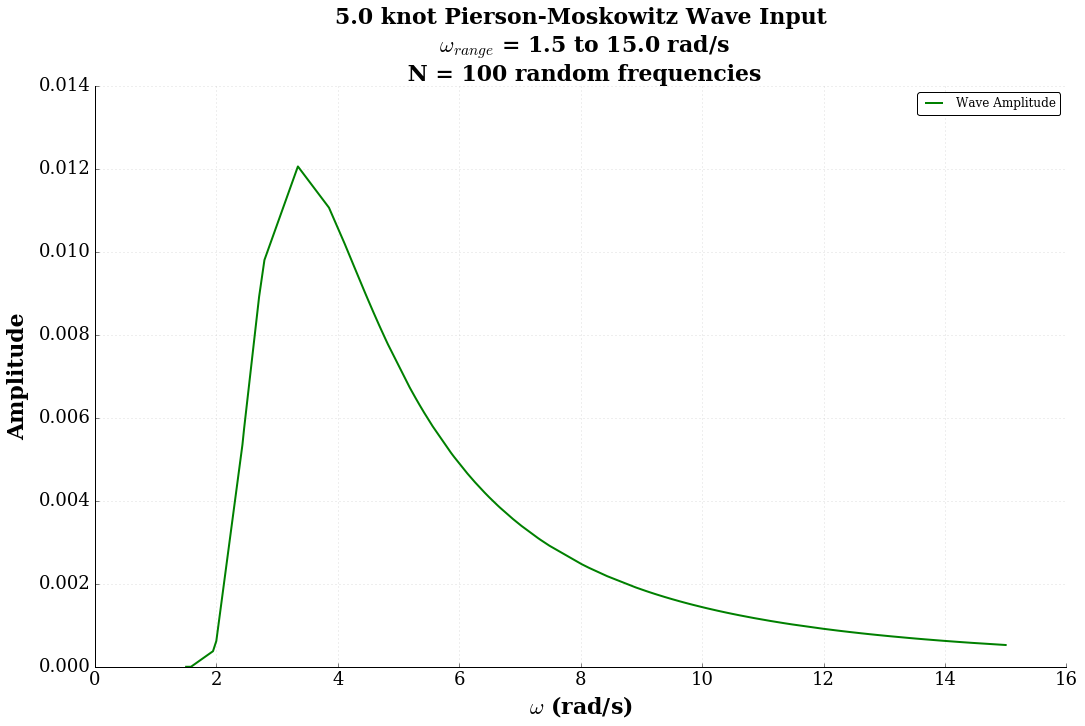

In [22]:
# Make the figure pretty, then plot the results
#   "pretty" parameters selected based on pdf output, not screen output
#   Many of these setting could also be made default by the .matplotlibrc file

# Set the plot size - 3x2 aspect ratio is best
fig = plt.figure(figsize=(15, 10)) #original (6,4)
ax = plt.gca()
plt.subplots_adjust(bottom=0.17, left=0.17, top=0.96, right=0.96)

# Change the axis units to serif
plt.setp(ax.get_ymajorticklabels(),family='serif',fontsize=18)
plt.setp(ax.get_xmajorticklabels(),family='serif',fontsize=18)

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Turn on the plot grid and set appropriate linestyle and color
ax.grid(True,linestyle=':',color='0.75')
ax.set_axisbelow(True)

# Define the X and Y axis labels
plt.xlabel('$\omega$ (rad/s)', family='serif', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Amplitude', family='serif', fontsize=22, weight='bold', labelpad=10)
plt.title('%s knot Pierson-Moskowitz Wave Input\n $\omega_{range}$ = %s to %s rad/s\n N = %s random frequencies'%(V_knots, OMEGA[0], OMEGA[-1], N), family='serif', fontsize=22, weight='bold')

# Plot the first element of resp for all time. It corresponds to the position.
#plt.plot(t, resp[:,3], linewidth=2, color='salmon', linestyle = '--', label=r'String Velocity')
plt.plot(OMEGA, A, linewidth=2, color='green', linestyle = '-', label=r'Wave Amplitude')
#plt.plot(t, total_wave, linewidth=2, color='lightgreen', linestyle = '-', label=r'Wave Height')

# uncomment below and set limits if needed
#plt.xlim(0,stoptime)
# ylim(0,10)

# Create the legend, then fix the fontsize
leg = plt.legend(loc='upper right', fancybox=True)
ltext  = leg.get_texts()
plt.setp(ltext,family='serif',fontsize=12)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad = 0.5)

# save the figure as a high-res pdf in the current folder
# It's saved at the original 6x4 size
#plt.savefig('%s knot Pierson-Moskowitz Wave Amplitude Spectrum %s to %s N = %s random frequencies Ideal Freq Range.pdf'%(V_knots, OMEGA[0], OMEGA[-1], N)) #change file name to match plotted variable

fig.set_size_inches(15, 10) # Resize the figure for better display in the notebook original (9,6)

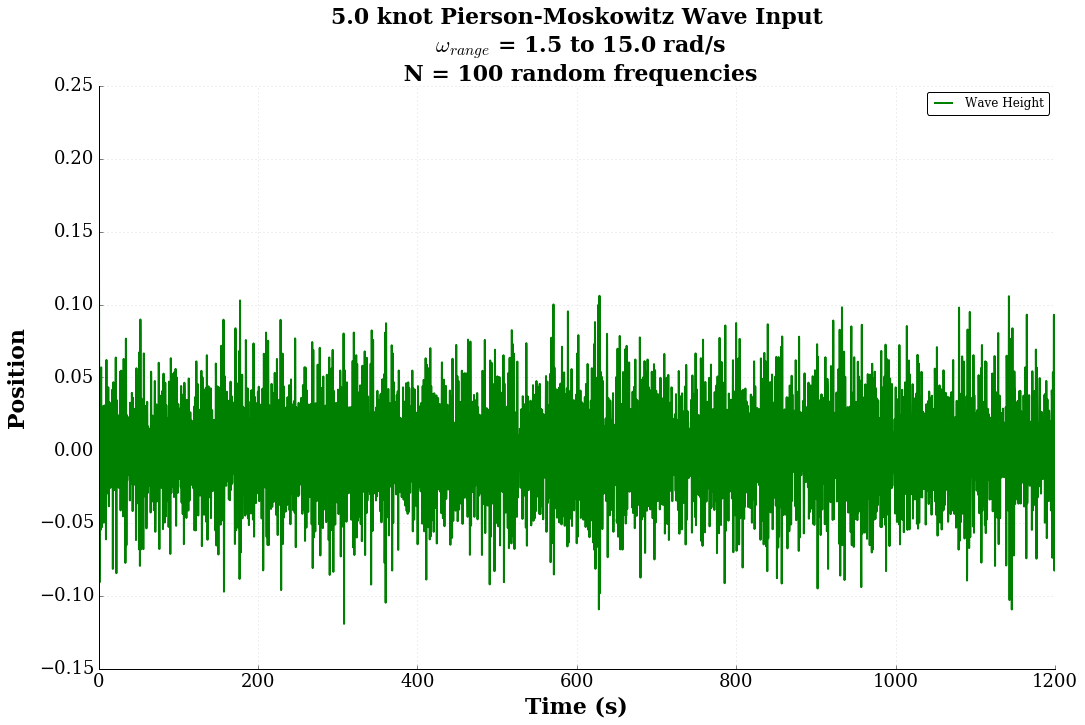

In [23]:
# Make the figure pretty, then plot the results
#   "pretty" parameters selected based on pdf output, not screen output
#   Many of these setting could also be made default by the .matplotlibrc file

# Set the plot size - 3x2 aspect ratio is best
fig = plt.figure(figsize=(15, 10)) #original (6,4)
ax = plt.gca()
plt.subplots_adjust(bottom=0.17, left=0.17, top=0.96, right=0.96)

# Change the axis units to serif
plt.setp(ax.get_ymajorticklabels(),family='serif',fontsize=18)
plt.setp(ax.get_xmajorticklabels(),family='serif',fontsize=18)

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Turn on the plot grid and set appropriate linestyle and color
ax.grid(True,linestyle=':',color='0.75')
ax.set_axisbelow(True)

# Define the X and Y axis labels
plt.xlabel('Time (s)', family='serif', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Position', family='serif', fontsize=22, weight='bold', labelpad=10)
plt.title('%s knot Pierson-Moskowitz Wave Input\n $\omega_{range}$ = %s to %s rad/s\n N = %s random frequencies'%(V_knots, OMEGA[0], OMEGA[-1], N), family='serif', fontsize=22, weight='bold')

# Plot the first element of resp for all time. It corresponds to the position.
#plt.plot(t, resp[:,0], linewidth=2, color='b', linestyle = '-', label=r'Ship Position')
#plt.plot(t, resp[:,1], linewidth=2, color='r', linestyle = '--', label=r'Ship Velocity')
#plt.plot(t, resp[:,2], linewidth=2, color='dodgerblue', linestyle = '-', label=r'String Position')
#plt.plot(t, resp[:,3], linewidth=2, color='salmon', linestyle = '--', label=r'String Velocity')
plt.plot(t, x_wave(t, p), linewidth=2, color='green', linestyle = '-', label=r'Wave Height')
#plt.plot(t, total_wave, linewidth=2, color='lightgreen', linestyle = '-', label=r'Wave Height')

# uncomment below and set limits if needed
plt.xlim(0,stoptime)
# ylim(0,10)

# Create the legend, then fix the fontsize
leg = plt.legend(loc='upper right', fancybox=True)
ltext  = leg.get_texts()
plt.setp(ltext,family='serif',fontsize=12)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad = 0.5)

# save the figure as a high-res pdf in the current folder
# It's saved at the original 6x4 size
#plt.savefig('%s knot Pierson-Moskowitz Wave Input %s to %s N = %s random frequencies Ideal Freq Range.pdf'%(V_knots, OMEGA[0], OMEGA[-1], N)) #change file name to match plotted variable

fig.set_size_inches(15, 10) # Resize the figure for better display in the notebook original (9,6)

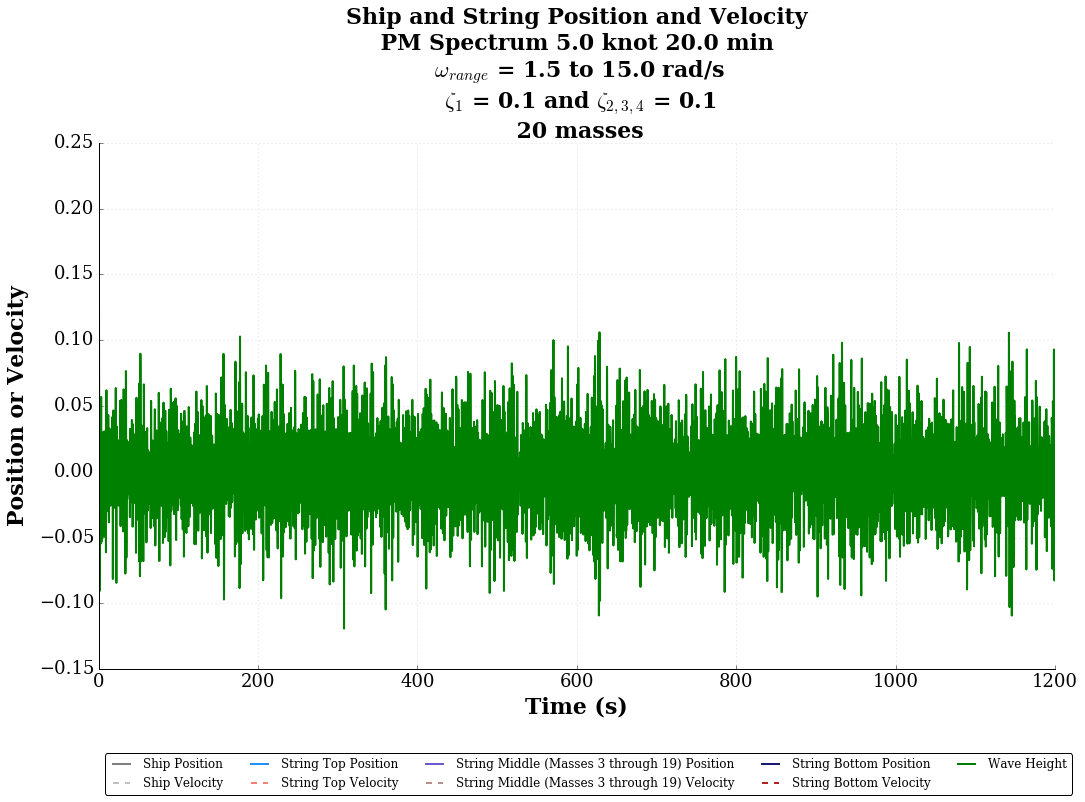

In [24]:
# Make the figure pretty, then plot the results
#   "pretty" parameters selected based on pdf output, not screen output
#   Many of these setting could also be made default by the .matplotlibrc file

# Set the plot size - 3x2 aspect ratio is best
fig = plt.figure(figsize=(15, 10)) #original (6,4)
ax = plt.gca()
plt.subplots_adjust(bottom=.17, left=0.17, top=0.96, right=0.96)   #bottom=0.17, left=0.17, top=0.96, right=0.96

# Change the axis units to serif
plt.setp(ax.get_ymajorticklabels(),family='serif',fontsize=18)
plt.setp(ax.get_xmajorticklabels(),family='serif',fontsize=18)

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Turn on the plot grid and set appropriate linestyle and color
ax.grid(True,linestyle=':',color='0.75')
ax.set_axisbelow(True)

# Define the X and Y axis labels
plt.xlabel('Time (s)', family='serif', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Position or Velocity', family='serif', fontsize=22, weight='bold', labelpad=10)
plt.title('Ship and String Position and Velocity\n PM Spectrum %s knot %s min \n $\omega_{range}$ = %s to %s rad/s \n $\zeta_1$ = %s and $\zeta_{2,3,4}$ = %s\n %s masses'%(V_knots, stoptimemin, OMEGA[0], OMEGA[-1], z0, z1, N_m), family='serif', fontsize=22, weight='bold')

# Plot the first element of resp for all time. It corresponds to the position.
plt.plot(t, resp[:,0], linewidth=2, color='grey', linestyle = '-', label=r'Ship Position')
plt.plot(t, resp[:,1], linewidth=2, color='silver', linestyle = '--', label=r'Ship Velocity')
plt.plot(t, resp[:,2], linewidth=2, color='dodgerblue', linestyle = '-', label=r'String Top Position')
plt.plot(t, resp[:,3], linewidth=2, color='salmon', linestyle = '--', label=r'String Top Velocity')
# Automate the plotting of the intermediate string masses
i = 3
j = 3
plt.plot(t, resp[:,i+1], linewidth=2, color='slateBlue', linestyle = '-', label=r'String Middle (Masses %d through %d) Position'%(j, N_ms))
plt.plot(t, resp[:,i+2], linewidth=2, color='rosybrown', linestyle = '--', label=r'String Middle (Masses %d through %d) Velocity'%(j, N_ms))
while i < 2 * (N_m - 2):
    plt.plot(t, resp[:,i+3], linewidth=2, color='slateBlue', linestyle = '-')
    plt.plot(t, resp[:,i+4], linewidth=2, color='rosybrown', linestyle = '--')
    j+=1
    i+=2
    
#plt.plot(t, resp[:,6], linewidth=2, color='slateBlue', linestyle = '-', label=r'String Middle 2 Position')
#plt.plot(t, resp[:,7], linewidth=2, color='rosybrown', linestyle = '--', label=r'String Middle 2 Velocity')
#plt.plot(t, resp[:,8], linewidth=2, color='slateBlue', linestyle = '-', label=r'String Middle 3 Position')
#plt.plot(t, resp[:,9], linewidth=2, color='rosybrown', linestyle = '--', label=r'String Middle 3 Velocity')
#plt.plot(t, resp[:,10], linewidth=2, color='slateBlue', linestyle = '-', label=r'String Middle 4 Position')
#plt.plot(t, resp[:,11], linewidth=2, color='rosybrown', linestyle = '--', label=r'String Middle 4 Velocity')
#plt.plot(t, resp[:,12], linewidth=2, color='slateBlue', linestyle = '-', label=r'String Middle 5 Position')
#plt.plot(t, resp[:,13], linewidth=2, color='rosybrown', linestyle = '--', label=r'String Middle 5 Velocity')
#plt.plot(t, resp[:,14], linewidth=2, color='slateBlue', linestyle = '-', label=r'String Middle 6 Position')
#plt.plot(t, resp[:,15], linewidth=2, color='rosybrown', linestyle = '--', label=r'String Middle 6 Velocity')
#plt.plot(t, resp[:,16], linewidth=2, color='slateBlue', linestyle = '-', label=r'String Middle 7 Position')
#plt.plot(t, resp[:,17], linewidth=2, color='rosybrown', linestyle = '--', label=r'String Middle 7 Velocity')
plt.plot(t, resp[:,-2], linewidth=2, color='midnightblue', linestyle = '-', label=r'String Bottom Position')
plt.plot(t, resp[:,-1], linewidth=2, color='firebrick', linestyle = '--', label=r'String Bottom Velocity')
plt.plot(t, x_wave(t, p), linewidth=2, color='green', linestyle = '-', label=r'Wave Height')

# uncomment below and set limits if needed
plt.xlim(0,stoptime)
# ylim(0,10)

# Create the legend, then fix the fontsize
leg = plt.legend(loc='lower left', fancybox=True, bbox_to_anchor=(.0, -.25), ncol=5)   
ltext  = leg.get_texts()
plt.setp(ltext,family='serif',fontsize=12)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad = 0.5)

# save the figure as a high-res pdf in the current folder
# It's saved at the original 6x4 size
#plt.savefig('Zoomed with w_nats %s knot %s min %s to %s with %s and %s damping ratios %s mass model.pdf'%(V_knots, stoptimemin, OMEGA[0], OMEGA[-1], z0, z1, N_m), bbox_extra_artists=(leg,), bbox_inches='tight') #change file name to match plotted variable

fig.set_size_inches(15, 10) # Resize the figure for better display in the notebook original (9,6)


In [37]:
# Make the figure pretty, then plot the results
#   "pretty" parameters selected based on pdf output, not screen output
#   Many of these setting could also be made default by the .matplotlibrc file

# Set the plot size - 3x2 aspect ratio is best
fig = plt.figure(figsize=(15, 10)) #original (6,4)
ax = plt.gca()
plt.subplots_adjust(bottom=0.17, left=0.17, top=0.96, right=0.96)

# Change the axis units to serif
plt.setp(ax.get_ymajorticklabels(),family='serif',fontsize=18)
plt.setp(ax.get_xmajorticklabels(),family='serif',fontsize=18)

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Turn on the plot grid and set appropriate linestyle and color
ax.grid(True,linestyle=':',color='0.75')
ax.set_axisbelow(True)

# Define the X and Y axis labels
plt.xlabel('Time (s)', family='serif', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Position', family='serif', fontsize=22, weight='bold', labelpad=10)
plt.title('Ship Position and Velocity\n PM Spectrum %s knot %s min \n $\omega_{range}$ = %s to %s rad/s \n $\zeta_1$ = %s and $\zeta_{2,3,4}$ = %s'%(V_knots, stoptimemin, OMEGA[0], OMEGA[-1], z0, z1), family='serif', fontsize=22, weight='bold')

# Plot the first element of resp for all time. It corresponds to the position.
plt.plot(t, resp[:,0], linewidth=2, color='grey', linestyle = '-', label=r'Ship Position')
plt.plot(t, resp[:,1], linewidth=2, color='silver', linestyle = '--', label=r'Ship Velocity')
#plt.plot(t, resp[:,2], linewidth=2, color='dodgerblue', linestyle = '-', label=r'String Position')
#plt.plot(t, resp[:,3], linewidth=2, color='salmon', linestyle = '--', label=r'String Velocity')

# uncomment below and set limits if needed
plt.xlim(0,stoptime)
# ylim(0,10)

# Create the legend, then fix the fontsize
leg = plt.legend(loc='upper right', fancybox=True)
ltext  = leg.get_texts()
plt.setp(ltext,family='serif',fontsize=18)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad = 0.5)

# save the figure as a high-res pdf in the current folder
# It's saved at the original 6x4 size
#plt.savefig('Ship Position and Velocity Reparied 2 mass model.pdf') #change file name to match plotted variable

fig.set_size_inches(15, 10) # Resize the figure for better display in the notebook original (9,6)

In [16]:
# Make the figure pretty, then plot the results
#   "pretty" parameters selected based on pdf output, not screen output
#   Many of these setting could also be made default by the .matplotlibrc file

# Set the plot size - 3x2 aspect ratio is best
fig = plt.figure(figsize=(15, 10)) #original (6,4)
ax = plt.gca()
plt.subplots_adjust(bottom=0.17, left=0.17, top=0.96, right=0.96)

# Change the axis units to serif
plt.setp(ax.get_ymajorticklabels(),family='serif',fontsize=18)
plt.setp(ax.get_xmajorticklabels(),family='serif',fontsize=18)

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Turn on the plot grid and set appropriate linestyle and color
ax.grid(True,linestyle=':',color='0.75')
ax.set_axisbelow(True)

# Define the X and Y axis labels
plt.xlabel('Time (s)', family='serif', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Position', family='serif', fontsize=22, weight='bold', labelpad=10)
plt.title('String Position and Velocity\n PM Spectrum %s knot %s min \n $\omega_{range}$ = %s to %s rad/s \n $\zeta_1$ = %s and $\zeta_{2,3,4}$ = %s'%(V_knots, stoptimemin, omega_1, omega_5, z1, z2), family='serif', fontsize=22, weight='bold')

# Plot the first element of resp for all time. It corresponds to the position.
#plt.plot(t, resp[:,0], linewidth=2, color='b', linestyle = '-', label=r'Ship Position')
#plt.plot(t, resp[:,1], linewidth=2, color='r', linestyle = '--', label=r'Ship Velocity')
plt.plot(t, resp[:,2], linewidth=2, color='dodgerblue', linestyle = '-', label=r'String Top Position')
plt.plot(t, resp[:,3], linewidth=2, color='salmon', linestyle = '--', label=r'String Top Velocity')
plt.plot(t, resp[:,4], linewidth=2, color='slateBlue', linestyle = '-', label=r'String Middle Position')
plt.plot(t, resp[:,5], linewidth=2, color='rosybrown', linestyle = '--', label=r'String Middle Velocity')
plt.plot(t, resp[:,6], linewidth=2, color='cadetblue', linestyle = '-', label=r'String Bottom Position')
plt.plot(t, resp[:,7], linewidth=2, color='indianred', linestyle = '--', label=r'String Bottom Velocity')
plt.plot(t, x_wave(t, p), linewidth=2, color='green', linestyle = '-', label=r'Wave Height')

# uncomment below and set limits if needed
plt.xlim(0,stoptime)
# ylim(0,10)

# Create the legend, then fix the fontsize
leg = plt.legend(loc='upper right', fancybox=True)
ltext  = leg.get_texts()
plt.setp(ltext,family='serif',fontsize=18)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad = 0.5)

# save the figure as a high-res pdf in the current folder
# It's saved at the original 6x4 size
#plt.savefig('String Position and Velocity Reparied 2 mass model.pdf') #change file name to match plotted variable

fig.set_size_inches(15, 10) # Resize the figure for better display in the notebook original (9,6)

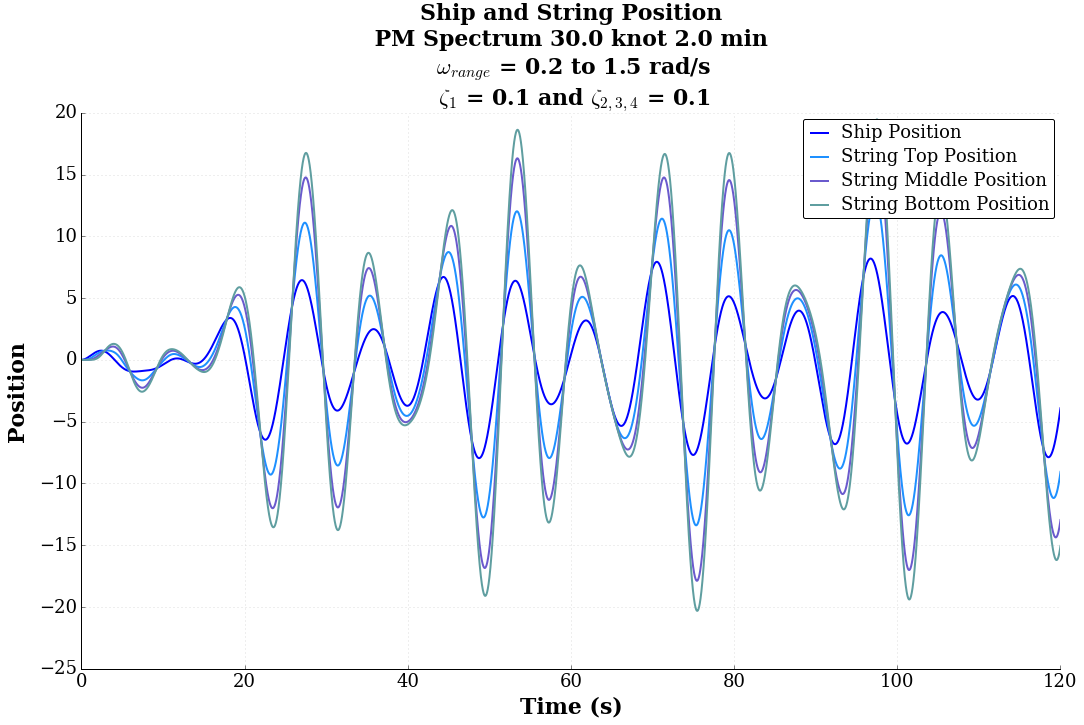

In [17]:
# Make the figure pretty, then plot the results
#   "pretty" parameters selected based on pdf output, not screen output
#   Many of these setting could also be made default by the .matplotlibrc file

# Set the plot size - 3x2 aspect ratio is best
fig = plt.figure(figsize=(15, 10)) #original (6,4)
ax = plt.gca()
plt.subplots_adjust(bottom=0.17, left=0.17, top=0.96, right=0.96)

# Change the axis units to serif
plt.setp(ax.get_ymajorticklabels(),family='serif',fontsize=18)
plt.setp(ax.get_xmajorticklabels(),family='serif',fontsize=18)

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Turn on the plot grid and set appropriate linestyle and color
ax.grid(True,linestyle=':',color='0.75')
ax.set_axisbelow(True)

# Define the X and Y axis labels
plt.xlabel('Time (s)', family='serif', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Position', family='serif', fontsize=22, weight='bold', labelpad=10)
plt.title('Ship and String Position\n PM Spectrum %s knot %s min \n $\omega_{range}$ = %s to %s rad/s \n $\zeta_1$ = %s and $\zeta_{2,3,4}$ = %s'%(V_knots, stoptimemin, omega_1, omega_5, z1, z2), family='serif', fontsize=22, weight='bold')

# Plot the first element of resp for all time. It corresponds to the position.
plt.plot(t, resp[:,0], linewidth=2, color='b', linestyle = '-', label=r'Ship Position')
#plt.plot(t, resp[:,1], linewidth=2, color='r', linestyle = '--', label=r'Ship Velocity')
plt.plot(t, resp[:,2], linewidth=2, color='dodgerblue', linestyle = '-', label=r'String Top Position')
#plt.plot(t, resp[:,3], linewidth=2, color='salmon', linestyle = '--', label=r'String Top Velocity')
plt.plot(t, resp[:,4], linewidth=2, color='slateBlue', linestyle = '-', label=r'String Middle Position')
#plt.plot(t, resp[:,5], linewidth=2, color='rosybrown', linestyle = '--', label=r'String Middle Velocity')
plt.plot(t, resp[:,6], linewidth=2, color='cadetblue', linestyle = '-', label=r'String Bottom Position')
#plt.plot(t, resp[:,7], linewidth=2, color='indianred', linestyle = '--', label=r'String Bottom Velocity')
#plt.plot(t, x_wave(t, p), linewidth=2, color='green', linestyle = '-', label=r'Wave Height')

# uncomment below and set limits if needed
plt.xlim(0,stoptime)
# ylim(0,10)

# Create the legend, then fix the fontsize
leg = plt.legend(loc='upper right', fancybox=True)
ltext  = leg.get_texts()
plt.setp(ltext,family='serif',fontsize=18)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad = 0.5)

# save the figure as a high-res pdf in the current folder
# It's saved at the original 6x4 size
#plt.savefig('Ship and String Position Reparied 2 mass model.pdf') #change file name to match plotted variable

fig.set_size_inches(15, 10) # Resize the figure for better display in the notebook original (9,6)

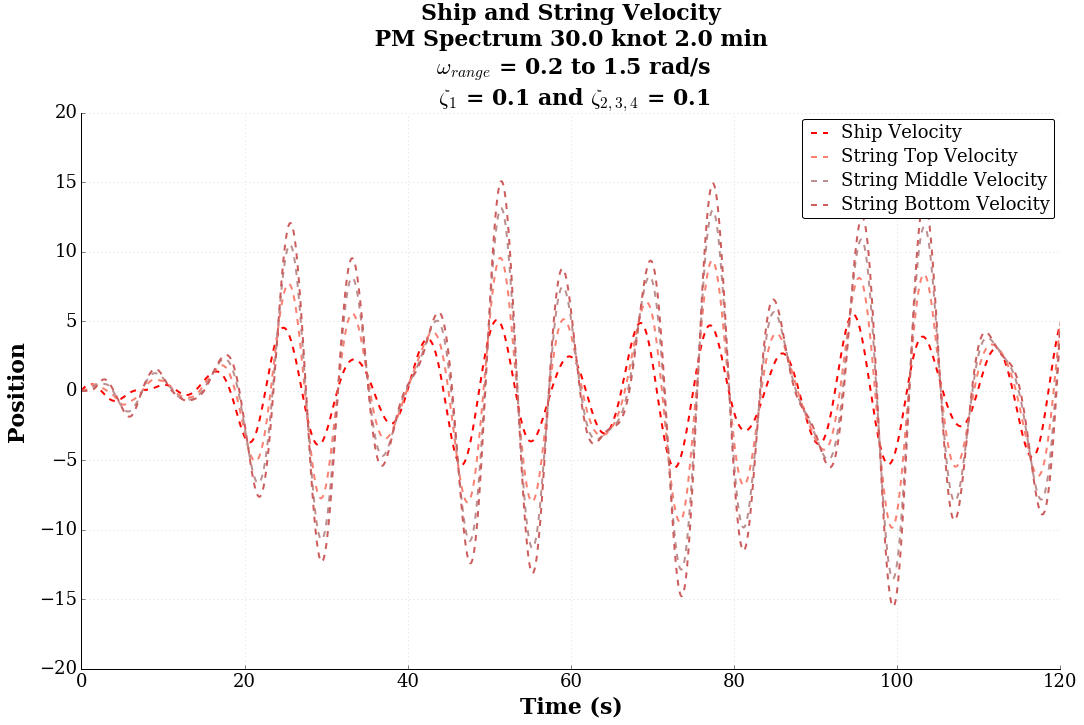

In [18]:
# Make the figure pretty, then plot the results
#   "pretty" parameters selected based on pdf output, not screen output
#   Many of these setting could also be made default by the .matplotlibrc file

# Set the plot size - 3x2 aspect ratio is best
fig = plt.figure(figsize=(15, 10)) #original (6,4)
ax = plt.gca()
plt.subplots_adjust(bottom=0.17, left=0.17, top=0.96, right=0.96)

# Change the axis units to serif
plt.setp(ax.get_ymajorticklabels(),family='serif',fontsize=18)
plt.setp(ax.get_xmajorticklabels(),family='serif',fontsize=18)

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Turn on the plot grid and set appropriate linestyle and color
ax.grid(True,linestyle=':',color='0.75')
ax.set_axisbelow(True)

# Define the X and Y axis labels
plt.xlabel('Time (s)', family='serif', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Position', family='serif', fontsize=22, weight='bold', labelpad=10)
plt.title('Ship and String Velocity\n PM Spectrum %s knot %s min \n $\omega_{range}$ = %s to %s rad/s \n $\zeta_1$ = %s and $\zeta_{2,3,4}$ = %s'%(V_knots, stoptimemin, omega_1, omega_5, z1, z2), family='serif', fontsize=22, weight='bold')

# Plot the first element of resp for all time. It corresponds to the position.
#plt.plot(t, resp[:,0], linewidth=2, color='b', linestyle = '-', label=r'Ship Position')
plt.plot(t, resp[:,1], linewidth=2, color='r', linestyle = '--', label=r'Ship Velocity')
#plt.plot(t, resp[:,2], linewidth=2, color='dodgerblue', linestyle = '-', label=r'String Top Position')
plt.plot(t, resp[:,3], linewidth=2, color='salmon', linestyle = '--', label=r'String Top Velocity')
#plt.plot(t, resp[:,4], linewidth=2, color='slateBlue', linestyle = '-', label=r'String Middle Position')
plt.plot(t, resp[:,5], linewidth=2, color='rosybrown', linestyle = '--', label=r'String Middle Velocity')
#plt.plot(t, resp[:,6], linewidth=2, color='cadetblue', linestyle = '-', label=r'String Bottom Position')
plt.plot(t, resp[:,7], linewidth=2, color='indianred', linestyle = '--', label=r'String Bottom Velocity')
#plt.plot(t, x_wave(t, p), linewidth=2, color='green', linestyle = '-', label=r'Wave Height')

# uncomment below and set limits if needed
plt.xlim(0,stoptime)
# ylim(0,10)

# Create the legend, then fix the fontsize
leg = plt.legend(loc='upper right', fancybox=True)
ltext  = leg.get_texts()
plt.setp(ltext,family='serif',fontsize=18)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad = 0.5)

# save the figure as a high-res pdf in the current folder
# It's saved at the original 6x4 size
#plt.savefig('Ship and String Velocity Reparied 2 mass model.pdf') #change file name to match plotted variable

fig.set_size_inches(15, 10) # Resize the figure for better display in the notebook original (9,6)

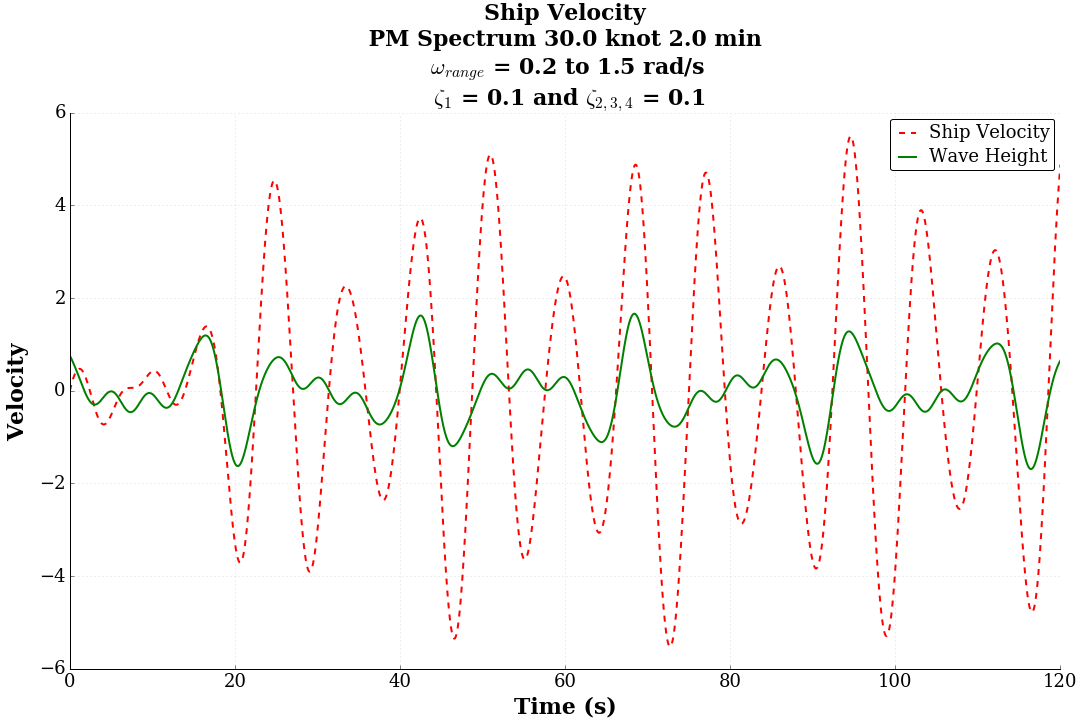

In [29]:
# Make the figure pretty, then plot the results - PLOTTING OTHER VARIABLES
#   "pretty" parameters selected based on pdf output, not screen output
#   Many of these setting could also be made default by the .matplotlibrc file

# Set the plot size - 3x2 aspect ratio is best
fig = plt.figure(figsize=(15, 10))
ax = plt.gca()
plt.subplots_adjust(bottom=0.17, left=0.17, top=0.96, right=0.96)

# Change the axis units to serif
plt.setp(ax.get_ymajorticklabels(),family='serif',fontsize=18)
plt.setp(ax.get_xmajorticklabels(),family='serif',fontsize=18)

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Turn on the plot grid and set appropriate linestyle and color
ax.grid(True,linestyle=':',color='0.75')
ax.set_axisbelow(True)

# Define the X and Y axis labels
plt.xlabel('Time (s)', family='serif', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Velocity', family='serif', fontsize=22, weight='bold', labelpad=10)
plt.title('Ship Velocity\n PM Spectrum %s knot %s min \n $\omega_{range}$ = %s to %s rad/s \n $\zeta_1$ = %s and $\zeta_{2,3,4}$ = %s'%(V_knots, stoptimemin, omega_1, omega_5, z1, z2), family='serif', fontsize=22, weight='bold')

# Plot the second element of resp for all time. It corresponds to the position.
#plt.plot(t, resp[:,0], linewidth=2, color='b', linestyle = '-', label=r'Ship Position')
plt.plot(t, resp[:,1], linewidth=2, color='r', linestyle = '--', label=r'Ship Velocity')
#plt.plot(t, resp[:,2], linewidth=2, color='dodgerblue', linestyle = '-', label=r'String Top Position')
#plt.plot(t, resp[:,3], linewidth=2, color='salmon', linestyle = '--', label=r'String Top Velocity')
#plt.plot(t, resp[:,4], linewidth=2, color='slateBlue', linestyle = '-', label=r'String Middle Position')
#plt.plot(t, resp[:,5], linewidth=2, color='rosybrown', linestyle = '--', label=r'String Middle Velocity')
#plt.plot(t, resp[:,6], linewidth=2, color='cadetblue', linestyle = '-', label=r'String Bottom Position')
#plt.plot(t, resp[:,7], linewidth=2, color='indianred', linestyle = '--', label=r'String Bottom Velocity')
plt.plot(t, x_wave(t, p), linewidth=2, color='green', linestyle = '-', label=r'Wave Height')

# uncomment below and set limits if needed
plt.xlim(0,stoptime)
# ylim(0,10)

# # Create the legend, then fix the fontsize
leg = plt.legend(loc='upper right', fancybox=True)
ltext  = leg.get_texts()
plt.setp(ltext,family='serif',fontsize=18)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad = 0.5)

# save the figure as a high-res pdf in the current folder
# It's saved at the original 6x4 size
#plt.savefig('Ship Velocity Reparied 2 mass model.pdf') #change file name to match plotted variable

fig.set_size_inches(15, 10) # Resize the figure for better display in the notebook original (9,6)

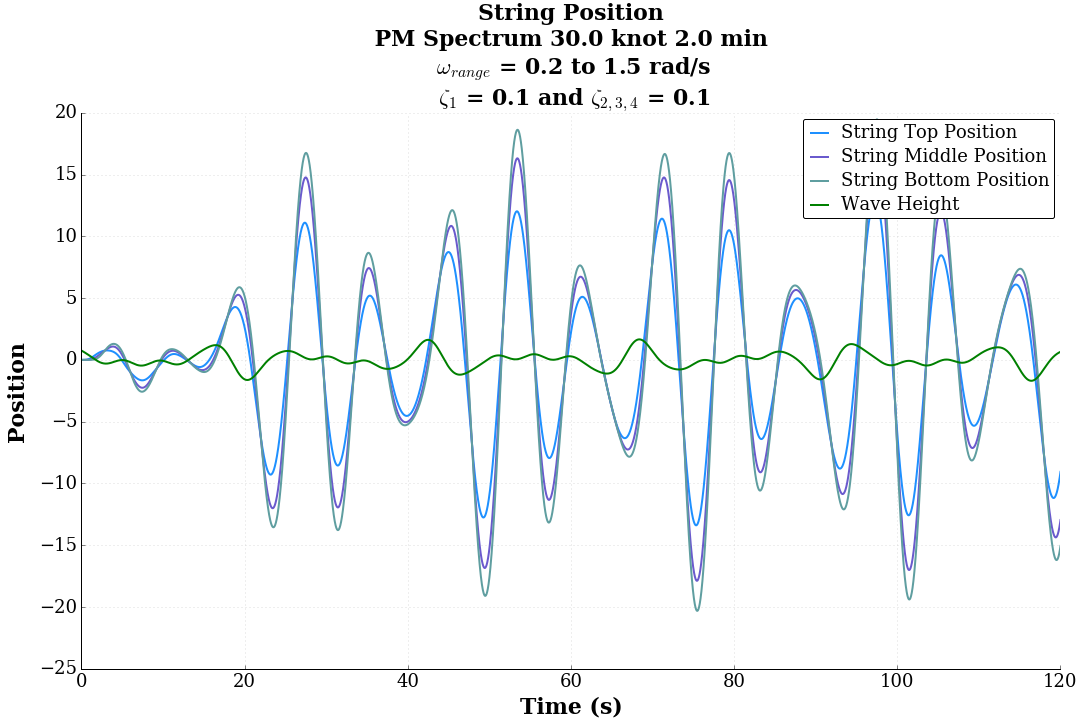

In [28]:
# Make the figure pretty, then plot the results - PLOTTING OTHER VARIABLES
#   "pretty" parameters selected based on pdf output, not screen output
#   Many of these setting could also be made default by the .matplotlibrc file

# Set the plot size - 3x2 aspect ratio is best
fig = plt.figure(figsize=(15, 10))
ax = plt.gca()
plt.subplots_adjust(bottom=0.17, left=0.17, top=0.96, right=0.96)

# Change the axis units to serif
plt.setp(ax.get_ymajorticklabels(),family='serif',fontsize=18)
plt.setp(ax.get_xmajorticklabels(),family='serif',fontsize=18)

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Turn on the plot grid and set appropriate linestyle and color
ax.grid(True,linestyle=':',color='0.75')
ax.set_axisbelow(True)

# Define the X and Y axis labels
plt.xlabel('Time (s)', family='serif', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Position', family='serif', fontsize=22, weight='bold', labelpad=10)
plt.title('String Position\n PM Spectrum %s knot %s min \n $\omega_{range}$ = %s to %s rad/s \n $\zeta_1$ = %s and $\zeta_{2,3,4}$ = %s'%(V_knots, stoptimemin, omega_1, omega_5, z1, z2), family='serif', fontsize=22, weight='bold')

# Plot the second element of resp for all time. It corresponds to the position.
#plt.plot(t, resp[:,0], linewidth=2, color='b', linestyle = '-', label=r'Ship Position')
#plt.plot(t, resp[:,1], linewidth=2, color='r', linestyle = '--', label=r'Ship Velocity')
plt.plot(t, resp[:,2], linewidth=2, color='dodgerblue', linestyle = '-', label=r'String Top Position')
#plt.plot(t, resp[:,3], linewidth=2, color='salmon', linestyle = '--', label=r'String Top Velocity')
plt.plot(t, resp[:,4], linewidth=2, color='slateBlue', linestyle = '-', label=r'String Middle Position')
#plt.plot(t, resp[:,5], linewidth=2, color='rosybrown', linestyle = '--', label=r'String Middle Velocity')
plt.plot(t, resp[:,6], linewidth=2, color='cadetblue', linestyle = '-', label=r'String Bottom Position')
#plt.plot(t, resp[:,7], linewidth=2, color='indianred', linestyle = '--', label=r'String Bottom Velocity')
plt.plot(t, x_wave(t, p), linewidth=2, color='green', linestyle = '-', label=r'Wave Height')

# uncomment below and set limits if needed
plt.xlim(0,stoptime)
# ylim(0,10)

# # Create the legend, then fix the fontsize
leg = plt.legend(loc='upper right', fancybox=True)
ltext  = leg.get_texts()
plt.setp(ltext,family='serif',fontsize=18)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad = 0.5)

# save the figure as a high-res pdf in the current folder
# It's saved at the original 6x4 size
#plt.savefig('String Position Reparied 2 mass model.pdf') #change file name to match plotted variable

fig.set_size_inches(15, 10) # Resize the figure for better display in the notebook original (9,6)

In [30]:
# Make the figure pretty, then plot the results - PLOTTING OTHER VARIABLES
#   "pretty" parameters selected based on pdf output, not screen output
#   Many of these setting could also be made default by the .matplotlibrc file

# Set the plot size - 3x2 aspect ratio is best
fig = plt.figure(figsize=(15, 10))
ax = plt.gca()
plt.subplots_adjust(bottom=0.17, left=0.17, top=0.96, right=0.96)

# Change the axis units to serif
plt.setp(ax.get_ymajorticklabels(),family='serif',fontsize=18)
plt.setp(ax.get_xmajorticklabels(),family='serif',fontsize=18)

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Turn on the plot grid and set appropriate linestyle and color
ax.grid(True,linestyle=':',color='0.75')
ax.set_axisbelow(True)

# Define the X and Y axis labels
plt.xlabel('Time (s)', family='serif', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Velocity', family='serif', fontsize=22, weight='bold', labelpad=10)
plt.title('String Velocity\n PM Spectrum %s knot %s min \n $\omega_{range}$ = %s to %s rad/s \n $\zeta_1$ = %s and $\zeta_{2,3,4}$ = %s'%(V_knots, stoptimemin, omega_1, omega_5, z1, z2), family='serif', fontsize=22, weight='bold')

# Plot the second element of resp for all time. It corresponds to the position.
#plt.plot(t, resp[:,0], linewidth=2, color='b', linestyle = '-', label=r'Ship Position')
#plt.plot(t, resp[:,1], linewidth=2, color='r', linestyle = '--', label=r'Ship Velocity')
#plt.plot(t, resp[:,2], linewidth=2, color='dodgerblue', linestyle = '-', label=r'String Top Position')
plt.plot(t, resp[:,3], linewidth=2, color='salmon', linestyle = '--', label=r'String Top Velocity')
#plt.plot(t, resp[:,4], linewidth=2, color='slateBlue', linestyle = '-', label=r'String Middle Position')
plt.plot(t, resp[:,5], linewidth=2, color='rosybrown', linestyle = '--', label=r'String Middle Velocity')
#plt.plot(t, resp[:,6], linewidth=2, color='cadetblue', linestyle = '-', label=r'String Bottom Position')
plt.plot(t, resp[:,7], linewidth=2, color='indianred', linestyle = '--', label=r'String Bottom Velocity')
plt.plot(t, x_wave(t, p), linewidth=2, color='green', linestyle = '-', label=r'Wave Height')

# uncomment below and set limits if needed
plt.xlim(0,stoptime)
# ylim(0,10)

# # Create the legend, then fix the fontsize
leg = plt.legend(loc='upper right', fancybox=True)
ltext  = leg.get_texts()
plt.setp(ltext,family='serif',fontsize=18)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad = 0.5)

# save the figure as a high-res pdf in the current folder
# It's saved at the original 6x4 size
#plt.savefig('String Velocity Reparied 2 mass model.pdf') #change file name to match plotted variable

fig.set_size_inches(15, 10) # Resize the figure for better display in the notebook original (9,6)

<hr class = "style-end">

#### Licenses
Code is licensed under a 3-clause BSD style license. See the licenses/LICENSE.md file.

Other content is provided under a [Creative Commons Attribution-NonCommercial 4.0 International License](http://creativecommons.org/licenses/by-nc/4.0/), CC-BY-NC 4.0.

In [8]:
# Ignore this cell - We just update the CSS to make the notebook look a little bit better and easier to read

# Improve the notebook styling -- Run this first
from IPython.core.display import HTML
css_file = 'styling/CRAWLAB_IPythonNotebook.css'
HTML(open(css_file, "r").read())